# CT Scan COVID-19 classifier using PyTorch

Recently, the UC San Diego open sourced a dataset containing lung CT Scan images of COVID-19 patients, the first of its kind in the public domain. In this post we will use PyTorch to build a classifier that takes the lung CT scan of a patient and classifies it as COVID-19 positive or negative.

However, let me add a **disclaimer** at the very beginning:

Let it be known that I am not a medical or radiology professional. My experience lies in machine learning, deep learning, and computer vision. Whatever I write comes from my limited knowledge of medical imaging. The results from this post should not be used in clinical studies or may be used at your own risk. I expect the code should be used to develop more robust classifiers that can be deployed in the real world.

I have followed several examples to arrive at this result, references to which is published at the end of this post.

Now, without wasting much time, let's jump into the code.
We start by importing the libraries.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from skimage.util import montage
import os
import cv2 
import random
import matplotlib.pyplot as plt 
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import glob
import shutil
import numpy as np
from torchvision.models import vgg19_bn
import numpy as np
import seaborn as sns
random.seed(0)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

We will start by cloning the GitHub repository to obtain the data along with all other information that we will need to process the data.

Please access the GitHub repository [here](https://github.com/UCSD-AI4H/COVID-CT).

In [2]:
!git clone https://github.com/UCSD-AI4H/COVID-CT

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5459, done.
remote: Total 5459 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5459/5459), 1.09 GiB | 22.39 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.


In [ ]:
!unzip  /content/COVID-CT/Images-processed/CT_COVID.zip;
!unzip /content/COVID-CT/Images-processed/CT_NonCOVID.zip;

## Dataset Description

Before we start building the classifier, let us discuss a bit about the dataset that we have with us.
We have a positive class with CT Scans of COVID-19 positive patients where as the negative class contains CT Scans of patients suffering from other ailments.

We must consider the facr that a doctor will never send a healthy patient for a CT Scan. In order to builda robust classifier, we must be aware that almost all the patients in our dataset will be suffering from some respiratory illness/ pneumonia.

Therefore, our classifier should be able to distinguish between COVID-19 induced pneumonia and other non-COVID-19 related respiratory illness/ pneumonia.



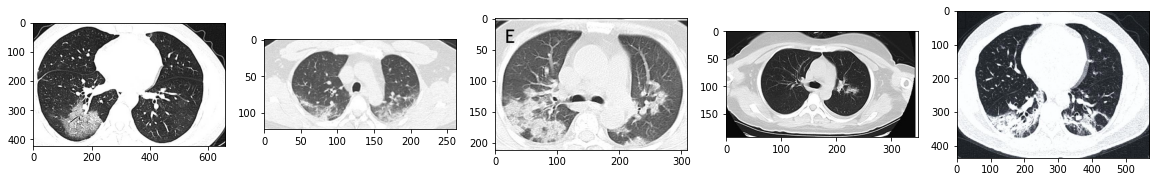

In [4]:
covid_files_path = '/content/CT_COVID'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

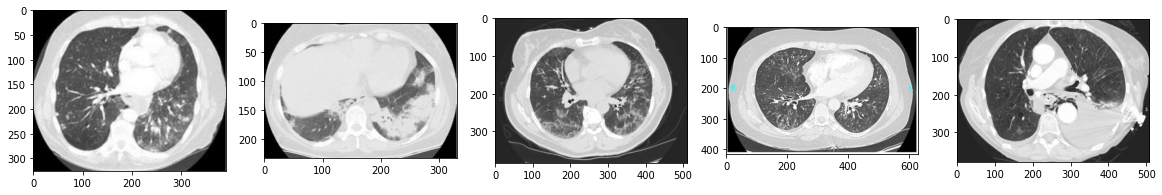

In [5]:
non_covid_files_path = '/content/CT_NonCOVID'
non_covid_files      = [os.path.join(non_covid_files_path, x) for x in os.listdir(non_covid_files_path)]
non_covid_images    =  [cv2.imread(x) for x in random.sample(non_covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(non_covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

## Loading Data

The entire dataset is divided into two 3 Splits: The train set, the test set and the validation set. The dataset details are described in this pre print: [COVID-CT-Dataset: A CT Scan Dataset about COVID-19](https://arxiv.org/pdf/2003.13865.pdf)

Details about the split is present inside the `Data-split` folder. This folder basically contains test files that explains which files belong to which split.

We create a function called `read_txt` to read the text files inside the `data-split` folder. We then We then create the `CovidCTScanDataset` class which basically subclasses the `torch.utils.data.Dataset` class.

In [6]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data


class CovidCTScanDataset(Dataset):

    def __init__(self, root_dir, classes, covid_files, non_covid_files, transform=None):
        
        self.root_dir = root_dir
        self.classes = classes
        self.files_path = [non_covid_files, covid_files]
        self.transform = transform
        self.image_list = []

        # read the files from data split text files
        covid_files = read_txt(covid_files)
        non_covid_files = read_txt(non_covid_files)

        # combine the positive and negative files into a cummulative files list
        for cls_index in range(len(self.classes)):
            
            class_files = [[os.path.join(self.root_dir, self.classes[cls_index], x), cls_index] \
                            for x in read_txt(self.files_path[cls_index])]
            self.image_list += class_files

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        path = self.image_list[idx][0]
        
        # Read the image
        image = Image.open(path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = int(self.image_list[idx][1])

        data = {'img':   image,
                'label': label,
                'paths' : path}

        return data

The dataset returns a dictionary containing the image tensor, the label tensor, and a list of image paths included in the batch.

## Image pre-processing and Data Augmentation

Here are the steps for Data pre-processing and augmentation:

A. Training set:

1. Resize the shorter side of the image to 256 while maintaining the aspect ratio
2. Randomly crop the image size ranging from 50% to 100% of the dimensions of the image. Finally, the crop is resized to 224 × 224
3. Horizontally flip the image with a probability of 0.5
4. Normalize the image to have 0 mean and standard deviation of 1

B. Testing set

1. Resize the image to 224 × 224.
2. Normalize the image to have mean 0 and standard deviation of 1

In [7]:
normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
train_transformer = transforms.Compose([
    transforms.Resize(256),  
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

We have  defined the `Dataset` and `DataLoader` classes, and now we shall instantiate them. We will use the label 0 for the non-COVID cases, whereas we use 1 for the COVID positive cases.

In [8]:
batchsize = 64

trainset = CovidCTScanDataset(root_dir='/content/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='/content/COVID-CT/Data-split/COVID/trainCT_COVID.txt',
                          non_covid_files='/content/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTScanDataset(root_dir='/content/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='/content/COVID-CT/Data-split/COVID/valCT_COVID.txt',
                          non_covid_files = '/content/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTScanDataset(root_dir='/content/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='/content/COVID-CT/Data-split/COVID/testCT_COVID.txt',
                          non_covid_files='/content/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

## Performance Metrics

Simply evaluating our model based on accuracy will not be enough. This is because of all the people we test, we are going to have only a few patients will be COVID-19 positive. This is because of the strong lockdown measures undertaken by the different governments t tackle this crisis.

In this scenario, we need to compute various metrics like Sesitivity, Specificity and Area under ROC.
Here is a description of the three different metrics:

1. **Specificity** : This metric will determine number of non-infected people that the model has classified as negative.

2. **Sensitivity** : This metric will determine the total number of infected people that the model has predicted as positive.

3. **Area under ROC** : It is a graph between Sensitivity and (1-Specificity). The area under the ROC curve can range from 0 to 1, where 1 represents the perfect classifier and 0.5 (meaning the curve follows the line y=x) represents a classifier which is as good as flipping a coin (random chance). An area under 0.5 means the classifier is even worse, and makes incorrect predictions more often than not.

Hence, We write the function `calc_metrics` to compute these metrics and some other quantities that will be useful for analysis later.


In [9]:
def calc_metrics(model, test_loader, plot_roc_curve = False):
    
    model.eval()
    
    val_loss = 0
    val_correct = 0
    
    criterion = nn.CrossEntropyLoss()
    
    score_list   = torch.Tensor([]).to(device)
    pred_list    = torch.Tensor([]).to(device).long()
    target_list  = torch.Tensor([]).to(device).long()
    path_list    = []

    
    for iter_num, data in enumerate(test_loader):
        
        # Convert image data into single channel data
        image, target = data['img'].to(device), data['label'].to(device)
        paths = data['paths']
        path_list.extend(paths)
        
        # Compute the loss
        with torch.no_grad():
            output = model(image)
        
        # Log loss
        val_loss += criterion(output, target.long()).item()

        
        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        val_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
        # Bookkeeping 
        score_list   = torch.cat([score_list, nn.Softmax(dim = 1)(output)[:,1].squeeze()])
        pred_list    = torch.cat([pred_list, pred.squeeze()])
        target_list  = torch.cat([target_list, target.squeeze()])
        
    
    classification_metrics = classification_report(target_list.tolist(), pred_list.tolist(),
                                                  target_names = ['CT_NonCOVID', 'CT_COVID'],
                                                  output_dict= True)
    
    
    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['CT_COVID']['recall']
    
    # specificity is the recall of the negative class 
    specificity = classification_metrics['CT_NonCOVID']['recall']
    
    # accuracy
    accuracy = classification_metrics['accuracy']
    
    # confusion matrix
    conf_matrix = confusion_matrix(target_list.tolist(), pred_list.tolist())
    
    # roc score
    roc_score = roc_auc_score(target_list.tolist(), score_list.tolist())
    
    # plot the roc curve
    if plot_roc_curve:
        fpr, tpr, _ = roc_curve(target_list.tolist(), score_list.tolist())
        plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
        plt.legend(loc = 'best')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    
    # put together values
    metrics_dict = {"Accuracy": accuracy,
                    "Sensitivity": sensitivity,
                    "Specificity": specificity,
                    "Roc_score"  : roc_score, 
                    "Confusion Matrix": conf_matrix,
                    "Validation Loss": val_loss / len(test_loader),
                    "score_list":  score_list.tolist(),
                    "pred_list": pred_list.tolist(),
                    "target_list": target_list.tolist(),
                    "paths": path_list}
    
    
    return metrics_dict

## The Model

We use the pretrained VGG-19 with batch normalization as our model. We then replace its final linear layer with one having 2 neurons at its output, and perform transfer learning over our dataset.

In [10]:
model = vgg19_bn(pretrained=True);
model.classifier[6] = nn.Linear(in_features=4096, out_features=2);
model.to(device);

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [11]:
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

## Early Stopping

We have implemented a class called `EarlyStopping` which is supposed to keep record of the moving average of loss and accuracy of the model during training. If the metric doesn't improve beyond a set number of epochs, defined by the variable`patience`, then the method `stop` returns:

- 0, if patience has not been exhausted for either accuracy or the loss

- 1, if patience is exhausted for both the accuracy and the loss

- 2, if patience has been exhausted only for accuracy

- 3, if patience has been exhausted only for loss

Please note that*** patience has been exhausted*** for a metric means that the metric has not been improving for a said number of epochs that is determined by the value we set for the`patience` variable.

In [12]:
from collections import deque

class EarlyStopping(object):
    def __init__(self, patience = 5):
        super(EarlyStopping, self).__init__()
        self.patience = patience
        self.previous_loss = int(1e8)
        self.previous_accuracy = 0
        self.init = False
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
        self.best_running_accuracy = 0
        self.best_running_loss = int(1e7)
    
    def add_data(self, model, loss, accuracy):
        
        # compute moving average
        if not self.init:
            running_loss = loss
            running_accuracy = accuracy 
            self.init = True
        
        else:
            running_loss = 0.2 * loss + 0.8 * self.previous_loss
            running_accuracy = 0.2 * accuracy + 0.8 * self.previous_accuracy
        
        # check if running accuracy has improved beyond the best running accuracy recorded so far
        if running_accuracy < self.best_running_accuracy:
            self.accuracy_decrease_iters += 1
        else:
            self.best_running_accuracy = running_accuracy
            self.accuracy_decrease_iters = 0
        
        # check if the running loss has decreased from the best running loss recorded so far
        if running_loss > self.best_running_loss:
            self.loss_increase_iters += 1
        else:
            self.best_running_loss = running_loss
            self.loss_increase_iters = 0
        
        # log the current accuracy and loss
        self.previous_accuracy = running_accuracy
        self.previous_loss = running_loss        
        
    
    def stop(self):
        
        # compute thresholds
        accuracy_threshold = self.accuracy_decrease_iters > self.patience
        loss_threshold = self.loss_increase_iters > self.patience
        
        
        # return codes corresponding to exhuaustion of patience for either accuracy or loss 
        # or both of them
        if accuracy_threshold and loss_threshold:
            return 1
        
        if accuracy_threshold:
            return 2
        
        if loss_threshold:
            return 3
        
        
        return 0
    
    def reset(self):
        # reset
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
    
early_stopper = EarlyStopping(patience = 2)

## Training the Model

- If the `early_stopper` object returns 3, which means the patience for loss is exhausted, we will multiply the `learning_rate` by 0.1

- If the `early_stopper` object returns 1, which means patience for both loss and accuracy has been exhausted, we will stop the training.

The reasons for such a policy is because Cross Entropy loss prefers high confidence predictions. So a more accurate model which is less confident about its predictions may have a higher loss than the model with lower accuracy but very confident predictions. Therefore, we make the decision only to stop training the model when the accuracy stops increasing as well.  

We also save the model with the highest accuracy with the name `best_model.pkl`

In [13]:
best_model = model
best_val_score = 0

criterion = nn.CrossEntropyLoss()

for epoch in range(60):

    model.train()    
    train_loss = 0
    train_correct = 0
    
    for iter_num, data in enumerate(train_loader):
        image, target = data['img'].to(device), data['label'].to(device)

        # Compute the loss
        output = model(image)
        loss = criterion(output, target.long())
        
        # Log loss
        train_loss += loss.item()
        loss.backward()

        # Perform gradient udpate
        optimizer.step()
        optimizer.zero_grad()
            

        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
    
    # Compute and print the performance metrics
    metrics_dict = calc_metrics(model, val_loader)
    print('------------------ Epoch {} Iteration {}--------------------------------------'.format(epoch,
                                                                                                 iter_num))
    print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
    print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
    print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
    print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
    print("Val Loss \t {}".format(metrics_dict["Validation Loss"]))
    print("------------------------------------------------------------------------------")
    
    # Save the model with best validation accuracy
    if metrics_dict['Accuracy'] > best_val_score:
        torch.save(model, "best_model.pkl")
        best_val_score = metrics_dict['Accuracy']
    
    
    # print the metrics for training data for the epoch
    print('\nTraining Performance Epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))

    # Add data to the EarlyStopper object
    early_stopper.add_data(model, metrics_dict['Validation Loss'], metrics_dict['Accuracy'])
    
    # If both accuracy and loss are not improving, stop the training
    if early_stopper.stop() == 1:
        break
    
    # if only loss is not improving, lower the learning rate
    if early_stopper.stop() == 3:
        for param_group in optimizer.param_groups:
            learning_rate *= 0.1
            param_group['lr'] = learning_rate
            print('Updating the learning rate to {}'.format(learning_rate))
            early_stopper.reset()
    

------------------ Epoch 0 Iteration 6--------------------------------------
Accuracy 	 0.525
Sensitivity 	 0.150
Specificity 	 0.914
Area Under ROC 	 0.544
Val Loss 	 1.0580639839172363
------------------------------------------------------------------------------

Training Performance Epoch 0: Average loss: 0.0101, Accuracy: 270/425 (64%)

------------------ Epoch 1 Iteration 6--------------------------------------
Accuracy 	 0.686
Sensitivity 	 0.567
Specificity 	 0.810
Area Under ROC 	 0.769
Val Loss 	 0.7278739809989929
------------------------------------------------------------------------------

Training Performance Epoch 1: Average loss: 0.0065, Accuracy: 334/425 (79%)

------------------ Epoch 2 Iteration 6--------------------------------------
Accuracy 	 0.695
Sensitivity 	 0.967
Specificity 	 0.414
Area Under ROC 	 0.803
Val Loss 	 1.1830564178526402
------------------------------------------------------------------------------

Training Performance Epoch 2: Average loss: 0

## Test the model

Here we will load our trained model and calculate the metrics on the test data.

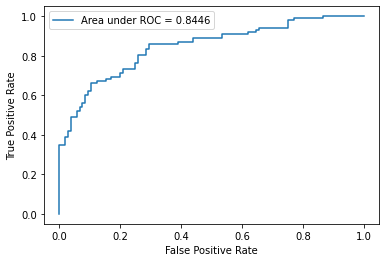

------------------- Test Performance --------------------------------------
Accuracy 	 0.749
Sensitivity 	 0.745
Specificity 	 0.752
Area Under ROC 	 0.845


In [14]:
model = torch.load("best_model.pkl" )

metrics_dict = calc_metrics(model, test_loader, plot_roc_curve = True)
print('------------------- Test Performance --------------------------------------')
print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))

[Text(0, 0.5, 'CoViD'), Text(0, 1.5, 'NonCoViD')]

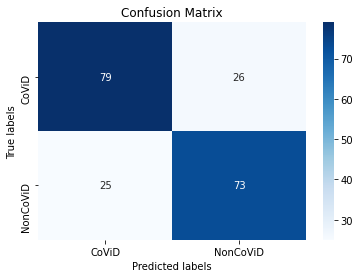

In [15]:
conf_matrix = metrics_dict["Confusion Matrix"]
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['CoViD', 'NonCoViD']); ax.yaxis.set_ticklabels(['CoViD', 'NonCoViD'])

## Recommendations : Scope for Improvements

1. **Need More Data** :  At only 746 examples, the dataset is too small for a model trained on it to be deployed in the real world. 

2. **Get Differentiated Data** : As have been observed earlier, the data for the negative class of the data set contains patients suffering from other respiratory ailments. Very few among them will be completely healthy patients. The performance would have been much better if we had labels separating the healthy patients from the non-healthy non-COVID ones. This is perhaps the reason why our model mistakes non-COVID opacities for COVID ones.

3. **Use Better Networks** : While we used a batch normalized VGG-19 pre-trained model, one can use advance architectures to learn the classifier. While transfer learning is a very successful technique, performing medical image application on models pretrained on ImageNet, a dataset of everyday items, may not be optimal.


## References

The below references have been extensively used to build this code set:
1. https://github.com/UCSD-AI4H/COVID-CT
2. https://blog.paperspace.com/fighting-coronavirus-with-ai-building-covid-19-classifier/
3. https://github.com/heysachin/Malaria-detection-pytorch
4. https://arxiv.org/pdf/2003.13865.pdf
5. https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/baseline%20methods/DenseNet169/DenseNet_predict.py